# M2 Mathématiques Appliquées, Statistique.
## Parcours Data Science
## Projets d'analyse d'électrocardiogrammes (ECG).
## Frédéric Richard

# 1. Présentation.

L'objectif de ce projet est de mettre en place des techniques de classification pour détecter des pathologies cardiaques à partir d'électrocardiogrammes chez les humains. 

On dispose d'un jeu de données de 162 électrocardiogrammes provenant de la base publique [PhysioNet]("https://www.physionet.org/"). Ce jeu de données comprend:

- 96 électrocardiogrammes de patients atteints d'arythmies cardiaques (ARR),
- 36 électrocardiogrammes de patients touchés par des insuffisances cardiaques congestives (CHR),
- 36 électrocardiogrammes présentant des rythmes sinusoidaux normaux (NSR).

Le jeu de données peut être téléchargé sur le site [github]("https://github.com/mathworks/physionet_ECG_data"). Une fois téléchargé le fichier EVGData.zip, il faut l'extraire dans un répertoire. Les données se trouvent dans le fichier matlab ECGData.mat. On peut ensuite importer ces données en python à l'aide du package *mat4py*.

Les ECG ont été échantillonnés à 128 Hz (128 échantillons par seconde) et comportent 65536 échantillons (soit 512 secondes d'enregistrement).

In [1]:
from mat4py import loadmat
data = loadmat('ECGData.mat')

M = len(data['ECGData']['Data'])
ecg = []
cl = []
for i in range(0, M):
    ecg.append(data['ECGData']['Data'][i])
    cl.append(data['ECGData']['Labels'][i])

La liste *ecg* comprend les ECG tandis que la liste *cl* comprend les classes. Des extraits des ECG peuvent être visualisés de la manière suivante.

Text(0.5, 0, 'Time (sec)')

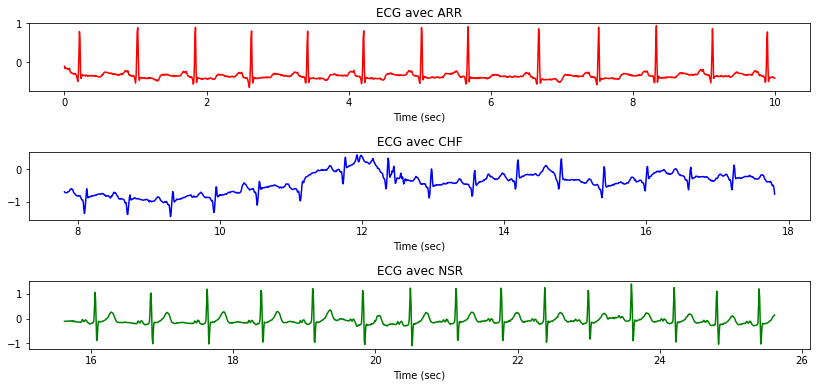

In [2]:
from matplotlib import pyplot as plt
import numpy as np

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 6))
fig.subplots_adjust(hspace=0.9)


T = len(ecg[0])  # 65536 échantillons
f0 = 128  # frame per second.
t = np.arange(T) / f0

ax1.plot(t[0:1280], ecg[0][0:1280], 'r-')
ax1.set_title('ECG avec ' + cl[0][0])
ax1.set_xlabel('Time (sec)')


ax2.plot(t[1000:2280], ecg[100][1000:2280], 'b-')
ax2.set_title('ECG avec ' + cl[100][0])
ax2.set_xlabel('Time (sec)')


ax3.plot(t[2000:3280], ecg[150][2000:3280], 'g-')
ax3.set_title('ECG avec ' + cl[150][0])
ax3.set_xlabel('Time (sec)')


# 2. Détection des complexes QRS.

L'électrocardiogramme donne une mesure de l'activité électrique du coeur. Cette activité est marquée par cinq déflexions caractéristiques, P, Q, R, S et T, qui se traduisent dans l'ECG par des ondes caractéristiques; voir l'article de wikidepia sur l'[électrocardiographie](https://fr.wikipedia.org/wiki/%C3%89lectrocardiographie) et la figure [Lecture ECG](https://fr.wikipedia.org/wiki/%C3%89lectrocardiographie#/media/Fichier:EKG_Complex_fr.svg).

Le complexe QRS est une caractéristique importante de l'ECG. Sa détection automatique est un problème d'intérêt qui fait encore l'objet de recherches; voir [état de l'art](https://people.ece.cornell.edu/land/courses/ece5030/labs/s2013/QRS_detect_review.pdf). Cette détection est complexe en raison de la variabilité du QRS. Elle est rendu difficile par la présence de bruits dus à des différents facteurs (par exemple, des interférences ou des mouvements de muscles), ainsiq que celles des autres ondes caractéristiques (ondes P et T) et d'une éventuelle dérive. On s'accorde à dire que l'essentiel du complexe QRS réside dans une bande de fréquence qui varie selon les auteurs. Aussi pour mettre en évidence le complexe QRS et atténuer les bruits et composantes de nuisance, on réalise souvent un prétraitement qui consiste à filtrer le signal ECG avec un filtre passe-bande dans la bande de fréquence de l'ECG. 

## 2.1. Réalisation d'un filtrage passe-bande.

Par le biais des ECG $f$ de la base de données, l'activité électrique du coeur $g$ est mesurée sur une période de temps $T$ (en seconde) à une fréquence  $f_0$ de  128 Hz (128 échantillons par seconde).

Soit $N =  f_0 T$ le nombre total d'échantillons. Pour $n = 1, \cdots, N$, on a

$$
f[n] = g\left( \frac{n}{f_0} \right).
$$

Par ailleurs, en supposant que $g$ est de carré intégrable sur $[0, T]$, on a 
$$ 
g(x) = \sum_{n \in \mathbb{Z}} \hat{g}_n e^{i\frac{2\pi}{T} n x}\quad \mathrm{avec} \quad \hat{g}_n  = \int_{[0,T]} g(y) e^{-i\frac{2\pi}{T} ny} dy. 
$$

Le coefficient $\hat{g}_n$  de Fourier de $g$ peut s'approcher par 

$$ \hat{g}_n  \simeq \frac{T}{N} \sum_{k=0}^{N-1} g\left(\frac{kT}{N} \right) e^{-i\frac{2\pi}{T} \frac{kT}{N} n}  = \frac{T}{N} \sum_{k=0}^{N-1} f[k] e^{-i\frac{2\pi kn}{N}} = T \hat{f}[n],  $$

où $\hat{f}$ est la **transformée de Fourier discrète** (TFD) de $f$. Autrement dit, à un facteur près, $\hat{f}[n]$ approche le coefficient de Fourier de $g$ correspondant à la fréquence $w_n = \frac{n}{T} = \frac{n}{N} f_0$.


La TFD d'un signal peut se calculer en Python à l'aide de la méthode *fft* du package *scipy*. Un [tutorial](https://docs.scipy.org/doc/scipy/reference/tutorial/fft.html) complet est également disponible.

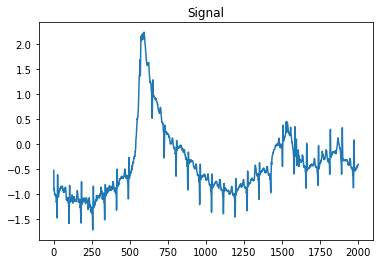

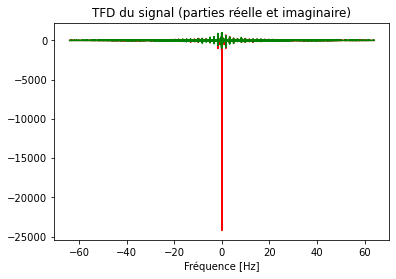

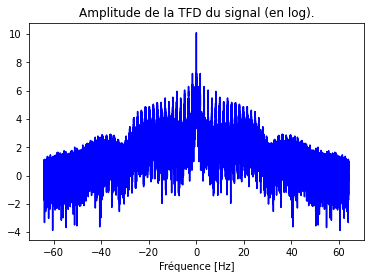

In [3]:
from scipy.fft import fft, fftshift, fftfreq, ifft
import numpy as np

f = np.array(ecg[100])  # Signal ECG sous forme de ndarray.
fh = fft(f)  # TFD du signal f.
freq = fftfreq(f.size, d=1/f0)  # Fréquences associées aux coefficients de la TFD.

# Visualisation d'un extrait du signal.
plt.figure(1)
plt.plot(f[0:2000])
fig1 = plt.title('Signal')

# Visualisation de la TFD en centrant sur la fréquence 0.
plt.figure(2)
plt.plot(fftshift(freq), fftshift(fh.real), 'r', fftshift(freq), fftshift(fh.imag), 'g')
fig1 = plt.title('TFD du signal (parties réelle et imaginaire)')
plt.xlabel('Fréquence [Hz]')

plt.figure(3)
plt.plot(fftshift(freq), fftshift(np.log(np.absolute(fh))), 'b')
fig2 = plt.title('Amplitude de la TFD du signal (en log).')
plt.xlabel('Fréquence [Hz]')


# Reconstruction à l'identique du signal d'origine f en appliquant la TFD inverse.
fs = ifft(fh)

**Exercice 1.** 

On cherche à mettre en évidence le complexe QRS dans l'ECG à l'aide d'un filtre passe-bande. On se fixe un seuil bas (par exemple, $s_b = 5$ Hz) et un seuil haut (par exemple, $s_h=15$ Hz). Dans le signal ECG, on élimine les composantes du spectre dont les fréquences sont, en valeur absolue, au-dessus de $s_h$ ou en dessous de $s_b$.

1. Préciser la fonction de transfert du filtre qui permet de réaliser cette opération.
2. Le mettre en oeuvre en python à l'aide de la TFD et de son inverse.
3. Comparer le signal filtré au filtre ECG original.

<ipython-input-4-857a53e54935>:2: ComplexWarning: Casting complex values to real discards the imaginary part
  power[:] = fh[:]


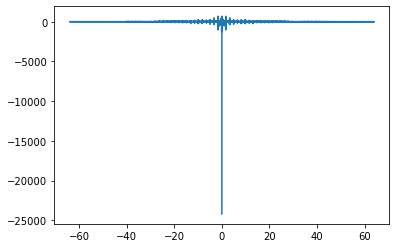

In [4]:
power = np.zeros(fh.shape)
power[:] = fh[:]
plt.plot(freq, power.real)
plt.show()

In [5]:
power[np.abs(freq)<5] = 0
power[np.abs(freq)>15] = 0

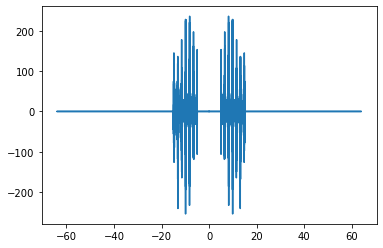

In [6]:
plt.plot(freq, power)
plt.show()

In [7]:
f_filtre = ifft(power)

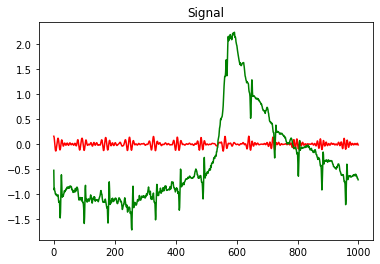

In [8]:
# Visualisation d'un extrait du signal.
plt.plot(f_filtre[0:1000].real, 'r-', f[0:1000], 'g-')
fig1 = plt.title('Signal')

## 2.2. Détection avec un filtre de Butterworth.

La méthode de détection proposée dans l'article de M. Elgendi, M. Jonkman et F. DeBoer de 2010 (voir Ametice) repose sur

- un prétraitement du signal avec un filtre de Butterworth passe-bande,
- une détection à partir de l'utilisation de deux moyennes mobiles.

Cette méthode est présentée dans les section 3.1 et 3.2 de l'article.


**Projet (Partie 1):**

Lire cet article, reproduire la méthode et l'expérimenter sur les données. 

Pour la définition et l'application d'un filtre de Butterworth, on pourra s'aider des méthodes *butter* et *sosfilt* du package *scipy.signal*. 

In [9]:
from scipy.signal import butter, sosfilt, sosfreqz
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs 
        low = lowcut / nyq  # Fréquence de nyquist
        high = highcut / nyq  # Fréquence de nyquist
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y


f0 = 128
lowcut = 8.0 
highcut = 20.0  


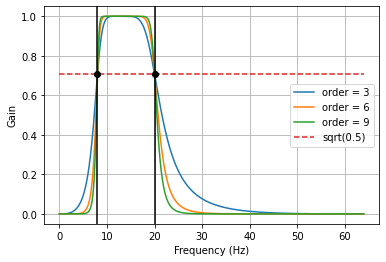

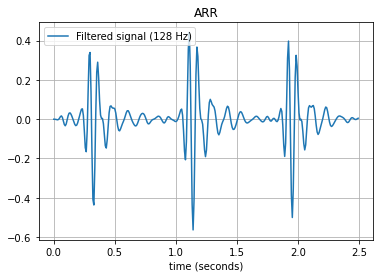

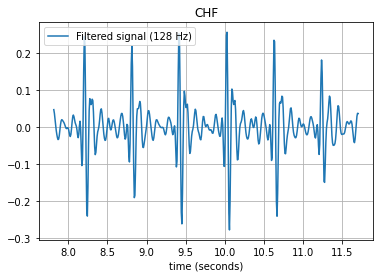

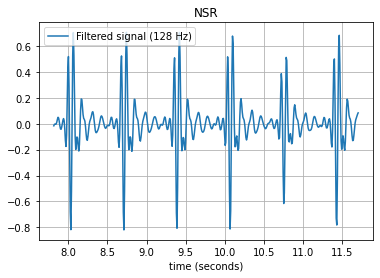

In [10]:
plt.figure(1)
plt.clf()
for order in [3, 6, 9]:
    sos = butter_bandpass(lowcut, highcut, f0, order=order)
    w, h = sosfreqz(sos, worN=8000)
    plt.plot((f0 * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * f0], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.plot(lowcut, 0.5*np.sqrt(2), 'ko')
plt.axvline(lowcut, color='k')
plt.plot(highcut, 0.5*np.sqrt(2), 'ko')
plt.axvline(highcut, color='k')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

# Creating the data for filteration
T = len(ecg[0])  # 65536 échantillons
f0 = 128  # frame per second.
t = np.arange(T) / f0

# Filter a noisy signal.
data = ecg[0]
plt.figure(2)
plt.clf()
#plt.plot(t[0:320], data[0:320], label='Noisy signal')
y = butter_bandpass_filter(data, lowcut, highcut, f0, order=6)
plt.plot(t[0:320], y[0:320], label='Filtered signal (%g Hz)'%f0)
plt.xlabel('time (seconds)')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
plt.title('ARR')

data = ecg[100]
plt.figure(3)
plt.clf()
#plt.plot(t[0:320], data[0:320], label='Noisy signal')
y = butter_bandpass_filter(data, lowcut, highcut, f0, order=6)
plt.plot(t[1000:1500], y[1000:1500], label='Filtered signal (%g Hz)'%f0)
plt.xlabel('time (seconds)')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
plt.title('CHF')

data = ecg[150]
plt.figure(4)
plt.clf()
#plt.plot(t[0:320], data[0:320], label='Noisy signal')
y = butter_bandpass_filter(data, lowcut, highcut, f0, order=6)
plt.plot(t[1000:1500], y[1000:1500], label='Filtered signal (%g Hz)'%f0)
plt.xlabel('time (seconds)')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
plt.title('NSR')

plt.show()



In [11]:
import numpy as np
from itertools import islice
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [12]:
def window(seq, n=44):
    it = iter(seq)
    result = tuple(islice(it, n))
    i = 0
    if len(result) == n:
        yield result, i
    for elem in it:
        result = result[1:] + (elem,)
        i += 1
        yield result, i

In [13]:
def block_of_interest(sig) : 
    
    MA_QRS = moving_average(sig,44)
    MA_BEAT = moving_average(sig,231)[93:-94]

    blocks = []
    for l1, l2 in zip(window(MA_QRS, n=44), window(MA_BEAT, n=44)):
        tmp = [i > j for i, j in zip(l1[0], l2[0])]
        blocks.append((l1[1], all(tmp)))

    block_clean = np.zeros(len(MA_QRS))
    for i, block in blocks:
        if block : 
            for j in range(44) : 
                block_clean[i+j] = 1
    return block_clean

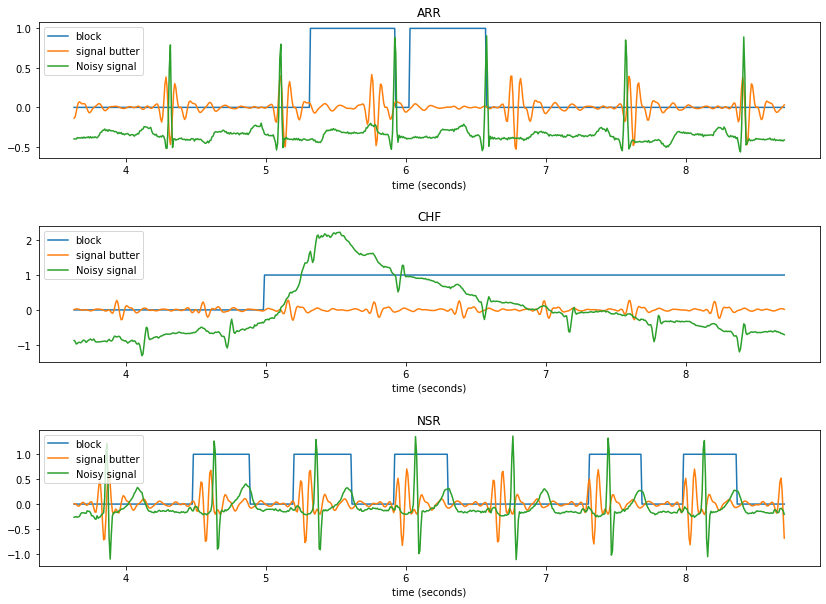

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10))
fig.subplots_adjust(hspace=0.5)

t_rac = t[115:-115]

####

y = butter_bandpass_filter(ecg[0], lowcut, highcut, f0, order=6)
y = y[115:-115]
block_clean = block_of_interest(ecg[0])
ax1.plot(t_rac[350:1000], block_clean[350:1000], label='block')
ax1.plot(t_rac[350:1000], y[350:1000], label='signal butter')
ax1.plot(t_rac[350:1000], ecg[0][350:1000], label='Noisy signal')
ax1.legend()
ax1.set_xlabel('time (seconds)')
ax1.set_title('ARR')

#####

y = butter_bandpass_filter(ecg[100], lowcut, highcut, f0, order=6)
y = y[115:-115]
block_clean = block_of_interest(ecg[100])
ax2.plot(t_rac[350:1000], block_clean[350:1000], label='block')
ax2.plot(t_rac[350:1000], y[350:1000], label='signal butter')
ax2.plot(t_rac[350:1000], ecg[100][350:1000], label='Noisy signal')
ax2.legend()
ax2.set_xlabel('time (seconds)')
ax2.set_title('CHF')

#####

y = butter_bandpass_filter(ecg[150], lowcut, highcut, f0, order=6)
y = y[115:-115]
block_clean = block_of_interest(ecg[150])
ax3.plot(t_rac[350:1000], block_clean[350:1000], label='block')
ax3.plot(t_rac[350:1000], y[350:1000], label='signal butter')
ax3.plot(t_rac[350:1000], ecg[150][350:1000], label='Noisy signal')
ax3.legend()
ax3.set_xlabel('time (seconds)')
ax3.set_title('NSR')
plt.show()

Nous pouvons voir que les blocks représentant la comparaison des deuc moyennes mobiles, comme décrit dans l'article, sont bien défini dans la condition où le sujet ne présente pas de problème cardiaque contrairement aux deux autres. Cette méthode permet donc de bien identifier les différences entre les patients sains et malade. 

# 3. Classification des ECG.

L'objectif de la classification est de déterminer à partir de l'ECG si le patient examiné est atteint ou non d'une des pathologies mentionnées en introduction. Nous allons étudier une méthode de classification décrite dans un [article](https://blog.octo.com/en/time-series-features-extraction-using-fourier-and-wavelet-transforms-on-ecg-data/) en ligne. et mise en oeuvre en python dans un [notebook](https://github.com/mnf2014/article_fft_wavelet_ecg/blob/develop/wavelet_article_octo.ipynb). Cette méthode repose sur l'utilisation de la transformée en ondelettes.

## 3.1. Scalogramme.

La transformée de Fourier d'un signal donne une représentation fréquentielle qui ne comporte pas d'information temporelle. La transformée en ondelette apporte une autre représentation qui véhicule à la fois des informations fréquentielle et temporelle. 

Etant donnés une fonction $\phi$, appelée ondelette, et un signal $f$, tous deux dans $L^2(\mathbb{R})$, on définit, pour $\alpha \in \R^\ast$ et $u \in \R$, la transformée en ondelette continue par
    
$$ 
    \tilde{f}_\psi(t, \alpha) = \int_{\mathbb{R}} f(u) \vert \alpha \vert^{\frac{1}{2}} \overline{\psi}(\alpha (u-t)) du  = \langle f,  \vert \alpha \vert^{\frac{1}{2}} \psi(\alpha (\cdot-t)) \rangle. 
$$
    
Cette transformée mesure une similarité de $f$ avec le motif $\psi$ dilaté (ou contracté) de $\vert \alpha \vert$ et positionné dans le voisinage de $t$.

La représentation du graphe $\{(t, \alpha), (\vert \tilde{f}_\psi(u, \alpha) \vert^2, u, \alpha)\}$ s'appelle un scalogramme. L'information véhiculée par le scalogramme peut s'analyser pour chaque position $t$ (axe des abscisses) et chaque échelle $\alpha$ (axe des ordonnées).

En python, il existe différents packages qui permettent de calculer le scalogramme d'un signal:

- la méthode [cwt](scipy.signal.cwt) du package **scipy.signal**,
- le package [pywt](https://github.com/PyWavelets/pywt) avec sa [documentation](https://pywavelets.readthedocs.io/en/latest/),
- le package [scaleogram](https://github.com/alsauve/scaleogram) basé sur *pywt*.

**Exercice 2.** 

Mettre en place un programme pour calculer le scalogramme d'un ECG en discutant du choix de l'ondelette et des échelles.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import pywt.data
import scaleogram as scg 

---
**Présentation des ondelettes mère**

In [16]:
pywt.families(False)

['Haar',
 'Daubechies',
 'Symlets',
 'Coiflets',
 'Biorthogonal',
 'Reverse biorthogonal',
 'Discrete Meyer (FIR Approximation)',
 'Gaussian',
 'Mexican hat wavelet',
 'Morlet wavelet',
 'Complex Gaussian wavelets',
 'Shannon wavelets',
 'Frequency B-Spline wavelets',
 'Complex Morlet wavelets']

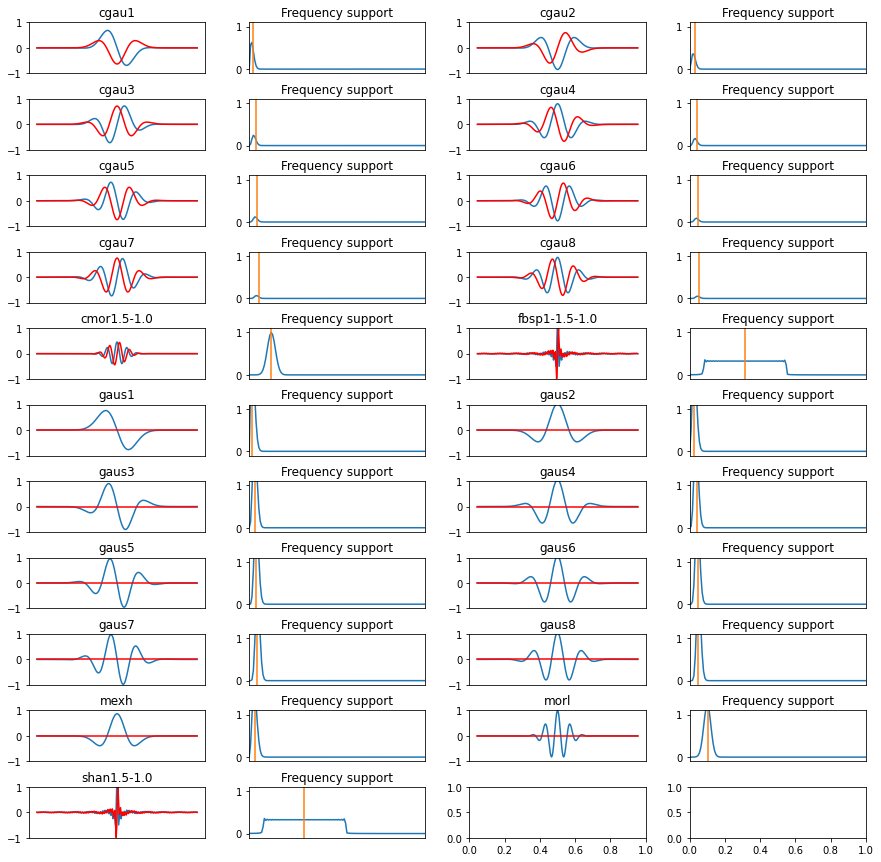

In [17]:
scg.plot_wavelets(figsize=(15,15))

Le choix de l'ondelette mère se faire en comparant le pattern d'un complexe QRS avec ceux des ondelettes mère affichées ci-contre. Nous pouvons observer que l'ondelettre Morelet est celle présentant les mêmes carasteristique que le complexe QRS. 

In [18]:
# choose default wavelet function 
scg.set_default_wavelet('morl')

**Scaleogramme**

Default wavelet function used to compute the transform: morl ( Morlet wavelet )


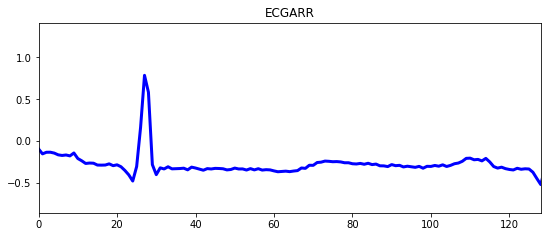

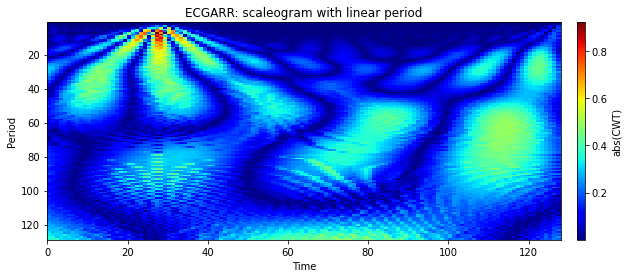

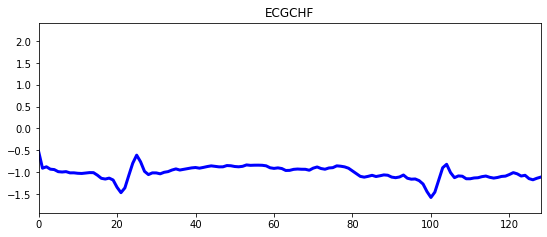

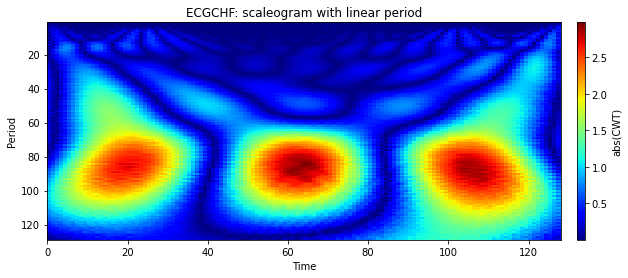

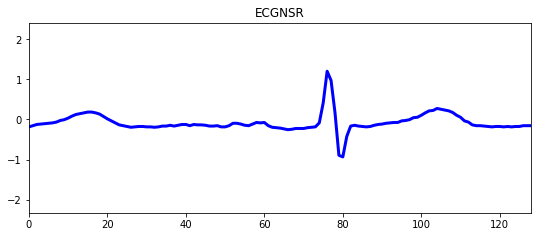

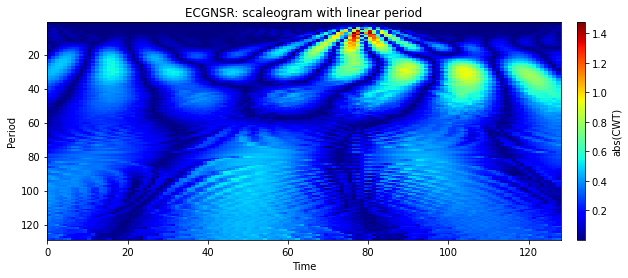

In [19]:
signal_length = 128

# range of scales to perform the transform
scales = scg.periods2scales( np.arange(1, signal_length+1) )
x_values_wvt_arr = range(0,len(ecg[0]),1)

##################

# plot the signal 
fig1, ax1 = plt.subplots(1, 1, figsize=(9, 3.5));  
ax1.plot(x_values_wvt_arr, ecg[0], linewidth=3, color='blue')
ax1.set_xlim(0, signal_length)
ax1.set_title("ECG" + cl[0][0])

# the scaleogram
scg.cws(ecg[0][:signal_length], scales=scales, figsize=(10, 4.0), coi = False, ylabel="Period", xlabel="Time",
        title='ECG' + cl[0][0]+': scaleogram with linear period'); 

##################

# plot the signal 
fig1, ax1 = plt.subplots(1, 1, figsize=(9, 3.5));  
ax1.plot(x_values_wvt_arr, ecg[100], linewidth=3, color='blue')
ax1.set_xlim(0, signal_length)
ax1.set_title("ECG" + cl[100][0])

# the scaleogram
scg.cws(ecg[100][:signal_length], scales=scales, figsize=(10, 4.0), coi = False, ylabel="Period", xlabel="Time",
        title='ECG' + cl[100][0]+': scaleogram with linear period'); 

##################

# plot the signal 
fig1, ax1 = plt.subplots(1, 1, figsize=(9, 3.5));  
ax1.plot(x_values_wvt_arr, ecg[150], linewidth=3, color='blue')
ax1.set_xlim(0, signal_length)
ax1.set_title("ECG" + cl[150][0])

# the scaleogram
scg.cws(ecg[150][:signal_length], scales=scales, figsize=(10, 4.0), coi = False, ylabel="Period", xlabel="Time",
        title='ECG' + cl[150][0]+': scaleogram with linear period'); 

print("Default wavelet function used to compute the transform:", scg.get_default_wavelet(), "(",
      pywt.ContinuousWavelet(scg.get_default_wavelet()).family_name, ")")

---
**Exemple de l'utilisation des ondelettes sur une image**

In [20]:
import pywt
cA, cD = pywt.dwt([1, 2, 3, 4], 'db1')

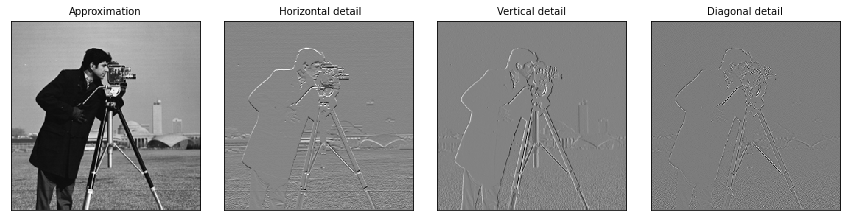

In [21]:
# Load image
original = pywt.data.camera()


# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']

coeffs2 = pywt.dwt2(original, 'bior1.3')

LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))

for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

---

## 3.2. Classification par réseau de neurones.

**Projet (Partie 2):** 

En s'inspirant de l'[article](https://blog.octo.com/en/time-series-features-extraction-using-fourier-and-wavelet-transforms-on-ecg-data/), construire un réseau de neurones pour classer les ECG, qui prend en entrée le scalogramme des ECG.

Evaluer ce réseau sur la base de données.

---
Cet article a été érit dans le cadre de développement de montre intelligente tel que la montre Embrace développé par Empatica. Cette dernière avait pour premier but de détecté les crises d'épilesie et s'est montré significativement performante pour la détectiond de crise cardiaque. 

https://www.empatica.com/index.html?utm_source=Google&utm_medium=Paid&utm_campaign=ADW_AO_BRND_CNV_1021&gclid=Cj0KCQiAqvaNBhDLARIsAH1Pq515ZW6vSFH1DdqPgsScbQ8h0ZLZHnR6asSALjS9_NTGiPYRsFjRhLsaAlSVEALw_wcB}

---

--- 
L'article nous présente les différentes techniques d'études de signaux comme la transformée de fourrier et la transformation en ondelettes. 

L'auteur nous explique que la **transformée de fourrier** nous permet d'extraire d'extraire les informations fréquentiels mais ne prend pas en compte les variations en fonctions du temps. Or, le rythme cardiaque n'est pas un motif parfait qui se répète au cours du temps. De plus, tout l'enjeu d'un déteteur de rythme cardique anormale se trouve dans cette variation au cours du temps. 

Il parait alors évident que l'utilisation de la **transorfée en ondelettes** serait l'outil approprié. En effet, elle permet de garder l'information temporelle. Cette dernière repose sur l'équation de la transformé de fourrier en cosinus, sinus mais dans le cas de l'ondelette le cosinus ne varie pas de $-\infty$ à $+\infty$. Ainsi, l'équation de la transformé en ondelettes est défini par un pas, une fenetre de translation et une fonction mère. 

---

In [22]:
#Preparing data
arr_list = ecg[0:95]
chf_list = ecg[96:125]
nsr_list = ecg[126:162]

arr_split_256 = [np.array_split(arr_list[ii], 256) for ii in range(95)] # signal découpé en morceau de 256 points 
arr_flatten = [item for sublist in arr_split_256 for item in sublist]  # 

chf_split_256 = [np.array_split(chf_list[ii], 256) for ii in range(29)]
chf_flatten = [item for sublist in chf_split_256 for item in sublist]

nsr_split_256 = [np.array_split(nsr_list[ii], 256) for ii in range(36)]
nsr_flatten = [item for sublist in nsr_split_256 for item in sublist]

La cellule au dessus découpe chaque signal de taille 65536 en 256 signaux de longueur 256. Cela permet d'obtenir 24320 signaux de longueur 256 pour ARR, 7424 signaux pour CHF et NSR. 


In [23]:
reduce_size = 500
full_1500 = (arr_flatten[0:reduce_size] + chf_flatten[0:reduce_size] + nsr_flatten[0:reduce_size])

full_1500 est une matrice contenant le même nombre de chaque type de signaux (ARR, NSR, CHF), soit 500 exemplaire de chaque. 

In [24]:
# create the data set
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


fs = len(full_1500[0])  # 256
sgn_length = 2000   #65536   
size_dataset = len(full_1500)
scales = range(1, fs)
waveletname = 'morl'
 
X_full = np.ndarray(shape=(size_dataset, fs-1, fs-1, 3))
                 
for i in range(0, size_dataset):
    if i % 500 == 0:
        print (i, 'done!')
    for j in range(0, 3):
        signal = full_1500[i]
        coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
        X_full[i, :, :, j] = coeff[:,:fs-1]

0 done!
500 done!
1000 done!


Cette cellule permet d'obtenir une matrice cotenant les transformés en ondelettes de chaque signal contenu dans full_1500. Chaque ligne est donc le scaléogramme de chaque signal. 

In [25]:
X_full[0].shape

(255, 255, 3)

Pour chaque signal nous avons 3 matrices de taille 255 x 255. 3 car le scaléogramme est une image pouvans être filtré en RGB, ainsi le modèle sera construit sur chaccune de ces informations. Néanmoins ces matrices sont, pour l'instant, identiques. 

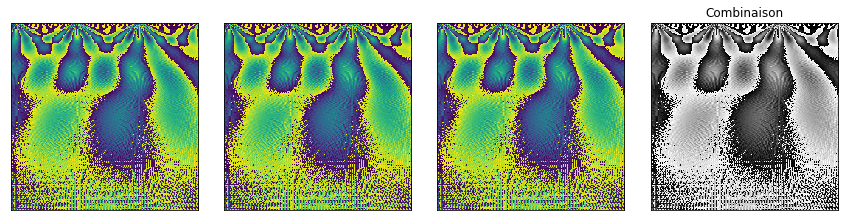

In [26]:
fig = plt.figure(figsize=(12, 3))

for i in range(4) : #,enumerate([LL, LH, HL, HH]):      
    ax = fig.add_subplot(1, 4, i + 1)
    if i > 2 : 
        ax.imshow((X_full[-1,:,:,:]*255).astype(np.uint8), interpolation="nearest")
        ax.set_title('Combinaison')
        ax.set_xticks([])
        ax.set_yticks([])
    else : 
        ax.imshow((X_full[-1,:,:,i]*255).astype(np.uint8), interpolation="nearest")#, cmap=plt.cm.gray)
        ax.set_xticks([])
        ax.set_yticks([])
    
fig.tight_layout()
plt.show()

In [27]:
# Cration des labels 
list_ecg_labels_arr = ['ARR']*reduce_size  # 500 ARR
list_ecg_labels_chf = ['CHF']*reduce_size  # 500 CHF
list_ecg_labels_nsr = ['NSR']*reduce_size  # 500 NSR
list_ecg_labels = (list_ecg_labels_arr + list_ecg_labels_chf + list_ecg_labels_nsr)


le = preprocessing.LabelEncoder()  # Label transformé en indice 
ecg_labels_encoded = le.fit_transform(list_ecg_labels)

In [28]:
for i, n in zip(range(3), ["ARR", "CHF", "NSR"]) : 
    print(le.classes_[i], '-->', le.transform([n]))


ARR --> [0]
CHF --> [1]
NSR --> [2]


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_full, ecg_labels_encoded, test_size=0.25, random_state=42)

Séparation des données en train, test. 

In [30]:
import sys
from tensorflow import keras

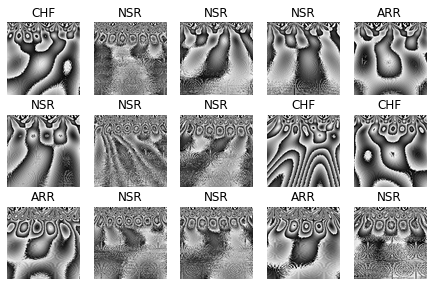

In [31]:
#Inspecting DATA
n_rows = 3
n_cols = 5
class_names = ['ARR', 'CHF', 'NSR']
plt.figure(figsize=(n_cols*1.5, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow((X_train[index]*255).astype(np.uint8), cmap="binary", interpolation="spline36")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.show()

In [32]:
# Defining basic NN
num_filter, num_classes = 3, 3
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[fs-1, fs-1, num_filter]),  #application de 3 filtre 1 sur chaque scaleogramme identique 
                                                                 #255*255*3
    keras.layers.Dense(300, activation="relu"),                 
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(num_classes, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd", metrics=["accuracy"])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 195075)            0         
                                                                 
 dense (Dense)               (None, 300)               58522800  
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 3)                 303       
                                                                 
Total params: 58,553,203
Trainable params: 58,553,203
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
36/36 [==============================] - 11s 273ms/step - loss: 0.8666 - accuracy: 0.6764 - val_loss: 0.8090 - val_accuracy: 0.7120
Epoch 2/10
36/36 [==============================] - 6s 160ms/step - loss: 0.2954 - accuracy: 0.8818 - val_loss: 0.3775 - val_accuracy: 0.8747
Epoch 3/10
36/36 [==============================] - 6s 165ms/step - loss: 0.1907 - accuracy: 0.9413 - val_loss: 0.2735 - val_accuracy: 0.9067
Epoch 4/10
36/36 [==============================] - 8s 222ms/step - loss: 0.0984 - accuracy: 0.9689 - val_loss: 0.9449 - val_accuracy: 0.7840
Epoch 5/10
36/36 [==============================] - 8s 225ms/step - loss: 0.0991 - accuracy: 0.9742 - val_loss: 0.1941 - val_accuracy: 0.9387
Epoch 6/10
36/36 [==============================] - 7s 200ms/step - loss: 0.0556 - accuracy: 0.9849 - val_loss: 0.1878 - val_accuracy: 0.9440
Epoch 7/10
36/36 [==============================] - 6s 172ms/step - loss: 0.0411 - accuracy: 0.9911 - val_loss: 0.1868 - val_accuracy: 0.9547
Epoch

In [35]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 1s 41ms/step - loss: 0.1882 - accuracy: 0.9600


[0.1881728321313858, 0.9599999785423279]

In [32]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.xlabel('epochs', size = 16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14) 
    plt.show()

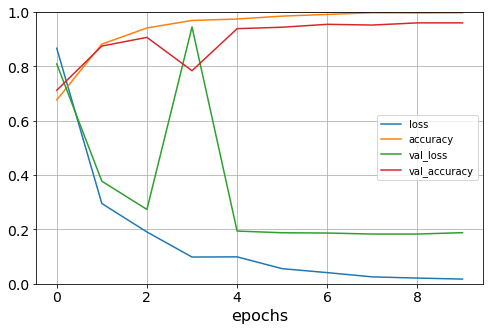

In [37]:
plot_learning_curves(history)

In [38]:
prediction = model.predict(X_test)
pred_classes = prediction.argmax(axis=1)

In [39]:
# Confusion Matrix With Scikit
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred_classes)
cm_norm =  cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

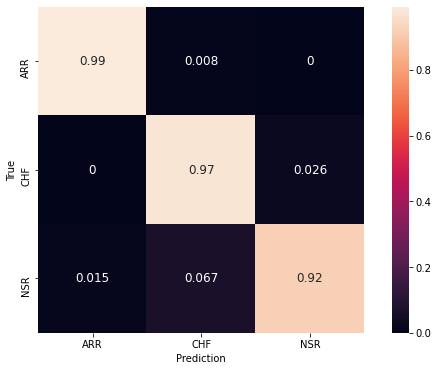

In [40]:
# Ploting Confusion Matrix
import seaborn as sns

df_cm = pd.DataFrame(cm_norm, ['ARR', 'CHF', 'NSR'], ['ARR', 'CHF', 'NSR'])
plt.figure(figsize = (10,6))
conf = sns.heatmap(df_cm, annot=True, square=True, annot_kws={"size": 12})
conf.set_xlabel('Prediction')
conf.set_ylabel('True')
plt.show()

In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_classes))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       125
           1       0.92      0.97      0.95       115
           2       0.98      0.92      0.95       135

    accuracy                           0.96       375
   macro avg       0.96      0.96      0.96       375
weighted avg       0.96      0.96      0.96       375



Cette table de metric nous en apprend un peu plus sur les capacités du model. 

Regardons la de plus près : 

- La **précision** renvoie le nombre de fois où la classe i à été prédite par rapport à toutes les prédictions. Ainsi, il donne une bonne indication du coût des faux positifs. Donc, nous cherchons ici à ce que les personnes présentant une maladie soit bien détectée et pas classées comme saines. Nous pouvons voir que la classe CHF (1) présente la précision la plus basse, mais en observant la matrice de confusion nous nous nous rendons compte que les faux positifs sont tous classés comme NSR (2) et non sain. Ce qui est toujours mieux que d'être classé comme sain, comme le fait CHF dans 1,6% des cas.  

- Le **recall** présente le nombre de signaux classés comme apparteanant à la bonne classe. Autrement dit, il permet de se rendre compte du nombre de signaux classés dans sa classe. Ici nous pouvons voir que NSR (2) n'a que 92% de ces signaux bien classés, 2,2% étant classés en sain ... Ce taux beaucoup plus important pour la pathologie NSR comparé à CHF peut s'expliquer par la ressemble plus importante de ce premier avec le signal sain ARR. 

- Le **F1-Score** est un type de score plus précis lorsque les données ne sont pas équilibrées. 

----

## Classification avec d'autre une architecture  

L'architecture précédente appliquait directement une couche dense aux données, or nous somme en présence d'images, alors j'ai décidé de tester des architectures de réseaux de neurones pour les images. Les quelques tests que j'ai déjà pu faire me permettent de supposer que l'auteur a du aussi tester mon approche, mais que le gain de précision du modèle a du être minime face au temps de traitement qu'une image demande. De plus, la détectition de de pattern anormaux en temps réel demande une prédiction très rapide. 

L'idée de tester sur des CNN me vient de la Stéganographie qui est une technique de dissimulation d'informations. En effet, il est possible de passer un message visuel crypté dans une source sonore. Le message devient alors visible lorsque la bande sonore est représenté grâce à un scaléogramme.  

In [42]:
num_filter, num_classes = 3, 3

input_shape = [fs-1, fs-1, num_filter]
model_LeNet = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Conv2D(filters=6, kernel_size=(5, 5), strides=1, activation="tanh"),
        keras.layers.AveragePooling2D(2*2, strides=2),
        keras.layers.Conv2D(filters=12, kernel_size=(5, 5), strides=1, activation="tanh"),
        keras.layers.AveragePooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

model_LeNet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 251, 251, 6)       456       
                                                                 
 average_pooling2d (AverageP  (None, 124, 124, 6)      0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 12)      1812      
                                                                 
 average_pooling2d_1 (Averag  (None, 60, 60, 12)       0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 43200)             0         
                                                                 
 dense_3 (Dense)             (None, 3)                

In [43]:
model_LeNet.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd", metrics=["accuracy"])

In [44]:
history_LeNet = model_LeNet.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
36/36 [==============================] - 22s 609ms/step - loss: 0.8508 - accuracy: 0.5938 - val_loss: 1.5766 - val_accuracy: 0.6187
Epoch 2/10
36/36 [==============================] - 20s 547ms/step - loss: 0.4601 - accuracy: 0.8187 - val_loss: 1.0113 - val_accuracy: 0.6480
Epoch 3/10
36/36 [==============================] - 20s 559ms/step - loss: 0.2768 - accuracy: 0.9076 - val_loss: 0.3300 - val_accuracy: 0.8533
Epoch 4/10
36/36 [==============================] - 20s 550ms/step - loss: 0.1322 - accuracy: 0.9689 - val_loss: 0.1590 - val_accuracy: 0.9520
Epoch 5/10
36/36 [==============================] - 20s 560ms/step - loss: 0.0854 - accuracy: 0.9813 - val_loss: 0.1229 - val_accuracy: 0.9653
Epoch 6/10
36/36 [==============================] - 20s 550ms/step - loss: 0.0610 - accuracy: 0.9840 - val_loss: 0.0883 - val_accuracy: 0.9787
Epoch 7/10
36/36 [==============================] - 20s 549ms/step - loss: 0.0497 - accuracy: 0.9884 - val_loss: 0.5065 - val_accuracy: 0.8613

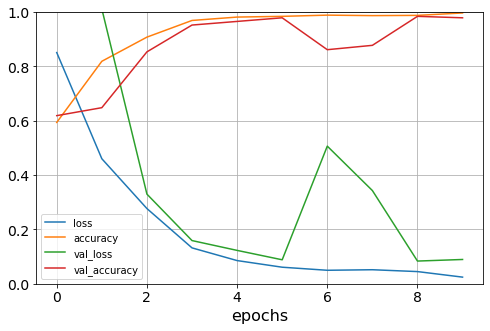

In [45]:
plot_learning_curves(history_LeNet)

In [46]:
model_LeNet.evaluate(X_test, y_test)

12/12 [==============================] - 2s 154ms/step - loss: 0.0895 - accuracy: 0.9787


[0.08948429673910141, 0.9786666631698608]

In [47]:
prediction_LeNet = model_LeNet.predict(X_test)
pred_classes_LeNet = prediction_LeNet.argmax(axis=1)
print(classification_report(y_test, pred_classes_LeNet))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       125
           1       0.97      0.97      0.97       115
           2       0.99      0.98      0.98       135

    accuracy                           0.98       375
   macro avg       0.98      0.98      0.98       375
weighted avg       0.98      0.98      0.98       375



In [48]:
from keras import models
layer_outputs = [layer.output for layer in model_LeNet.layers[:7]] 
# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model_LeNet.input, outputs=layer_outputs) 
# Creates a model that will return these outputs, given the model input

In [50]:
X0_test = X_test[1].reshape(255, 255,3)
print(X0_test.shape)
X0_test = np.expand_dims(X0_test, axis=0)
print(X0_test.shape)

(255, 255, 3)
(1, 255, 255, 3)


In [51]:
activations = activation_model.predict(X0_test) 
# Returns a list of five Numpy arrays: one array per layer activation

In [52]:
first_layer_activation = activations[0]
print('Shape of first layer',first_layer_activation.shape)

Shape of first layer (1, 251, 251, 6)


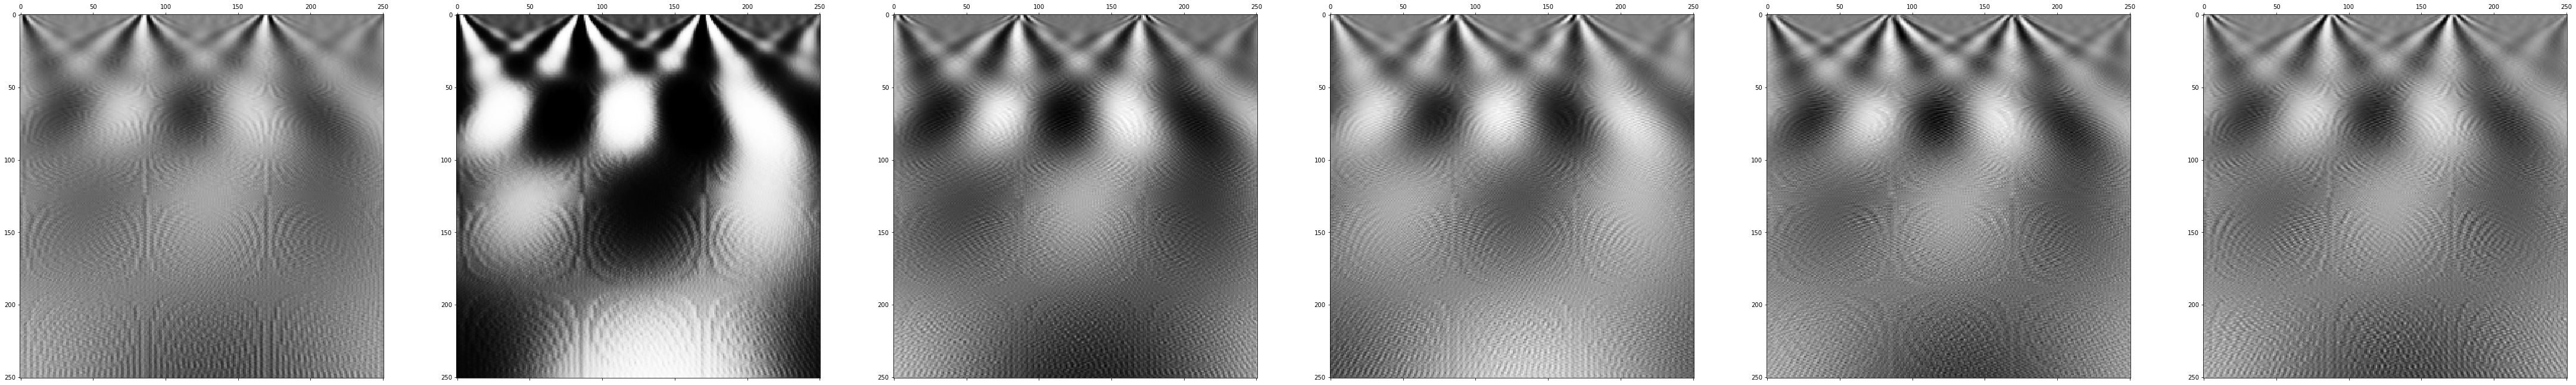

In [53]:
from keras.preprocessing import image
from matplotlib.gridspec import  GridSpec

ncols = 6
nrows = 1
grid = GridSpec(nrows, ncols,left=0.1, bottom=0.05, right=10, top=10)
fig = plt.figure(0)
fig.clf()


ax = []
first_layer_activation = activations[0]
for i in range(ncols) : 
    ax.append(fig.add_subplot(grid[0, i]))
for i in range(ncols) : 
    ax[i].matshow(first_layer_activation[0, :, :, i], cmap="binary")

plt.show()

Shape of first layer (1, 124, 124, 6)


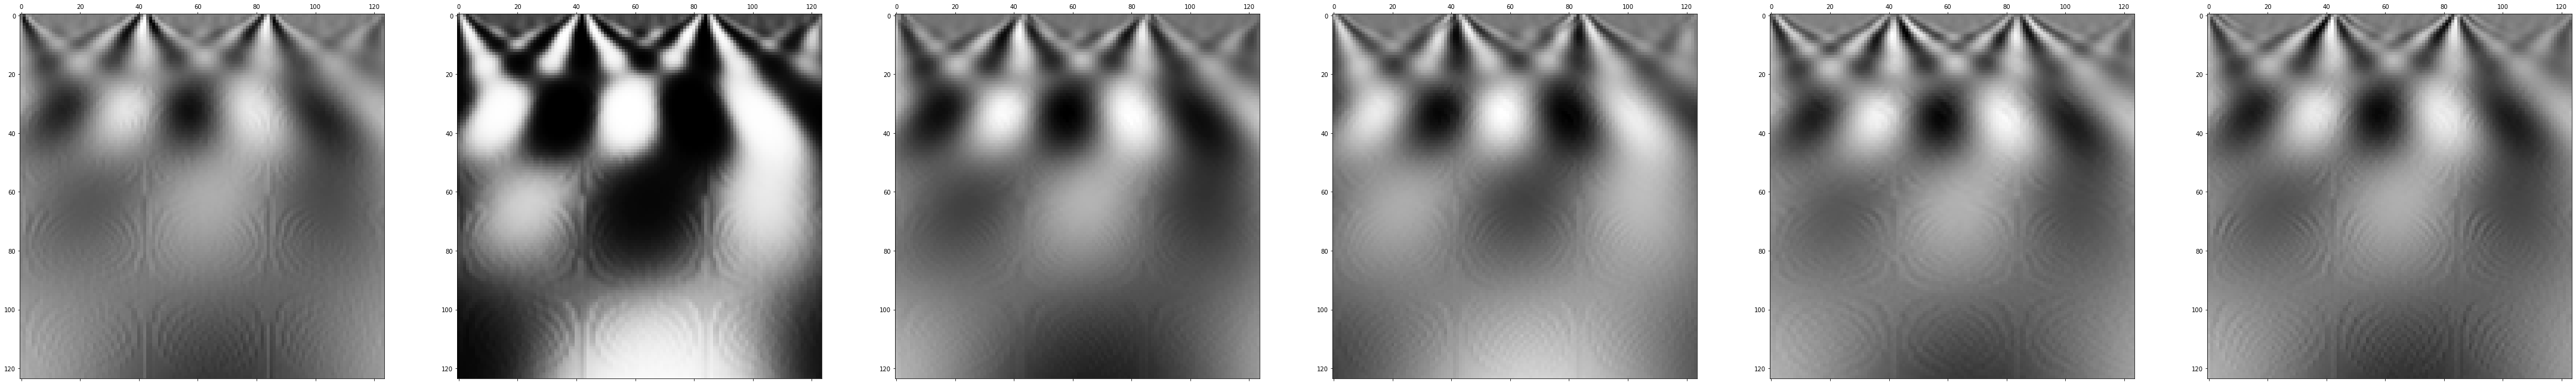

In [54]:
ncols = 6
nrows = 1
grid = GridSpec(nrows, ncols,left=0.1, bottom=0.05, right=10, top=10)
fig = plt.figure(0)
fig.clf()

ax = []
first_layer_activation = activations[1]
print('Shape of first layer',first_layer_activation.shape)
for i in range(ncols) : 
    ax.append(fig.add_subplot(grid[0, i]))
for i in range(ncols) : 
    ax[i].matshow(first_layer_activation[0, :, :, i], cmap="binary")

plt.show()

Shape of first layer (1, 120, 120, 12)


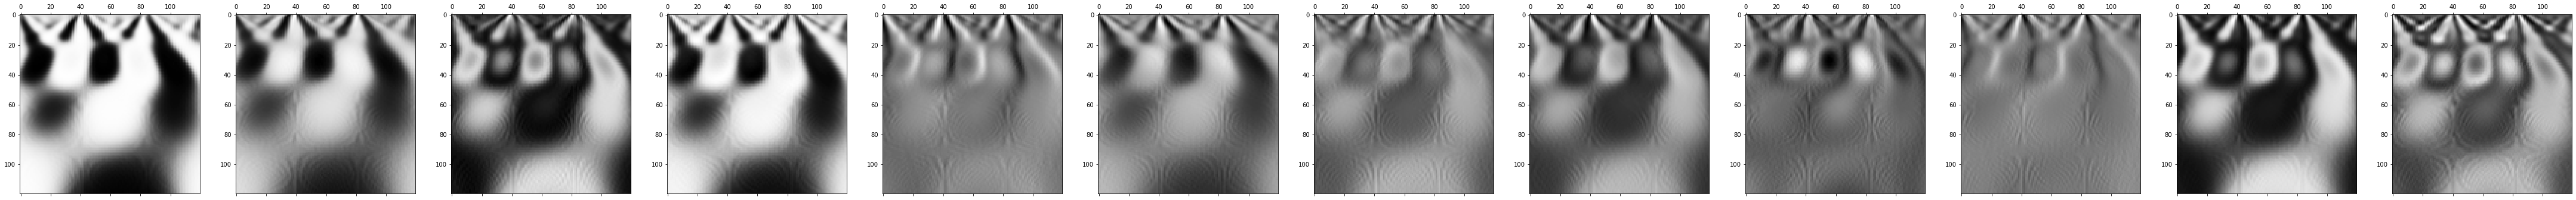

In [55]:
ncols = 12
nrows = 1
grid = GridSpec(nrows, ncols,left=0.1, bottom=0.05, right=10, top=10)
fig = plt.figure(0)
fig.clf()

ax = []
first_layer_activation = activations[2]
print('Shape of first layer',first_layer_activation.shape)
for i in range(ncols) : 
    ax.append(fig.add_subplot(grid[0, i]))
for i in range(ncols) : 
    ax[i].matshow(first_layer_activation[0, :, :, i], cmap="binary")

plt.show()

La taille des images étant de grande dimension et les fenètres du modèles de petites, nous abservons des couches qui qui se ressemblent. Le modèle est assez long à traiter les donnés de test mais les résultats sont assez bons. 

---

In [56]:
input_shape = [fs-1, fs-1, num_filter]
model_CWT = keras.Sequential(
    [
    keras.Input(shape=input_shape),
    keras.layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1),activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    keras.layers.Conv2D(3, (5, 5), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
    ]
)
model_CWT.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 251, 251, 6)       456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 125, 6)      0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 121, 121, 3)       453       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 60, 3)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 10800)             0         
                                                                 
 dense_4 (Dense)             (None, 100)              

In [57]:
model_CWT.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd", metrics=["accuracy"])

In [58]:
history_CWT = model_CWT.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
36/36 [==============================] - 20s 525ms/step - loss: 0.5953 - accuracy: 0.7493 - val_loss: 0.3862 - val_accuracy: 0.8080
Epoch 2/10
36/36 [==============================] - 18s 513ms/step - loss: 0.2210 - accuracy: 0.9342 - val_loss: 0.1011 - val_accuracy: 0.9840
Epoch 3/10
36/36 [==============================] - 22s 619ms/step - loss: 0.1468 - accuracy: 0.9564 - val_loss: 0.0559 - val_accuracy: 0.9920
Epoch 4/10
36/36 [==============================] - 19s 538ms/step - loss: 0.0763 - accuracy: 0.9787 - val_loss: 0.0631 - val_accuracy: 0.9920
Epoch 5/10
36/36 [==============================] - 19s 519ms/step - loss: 0.0830 - accuracy: 0.9778 - val_loss: 0.0997 - val_accuracy: 0.9760
Epoch 6/10
36/36 [==============================] - 19s 516ms/step - loss: 0.0313 - accuracy: 0.9956 - val_loss: 0.0409 - val_accuracy: 0.9920
Epoch 7/10
36/36 [==============================] - 18s 512ms/step - loss: 0.0107 - accuracy: 0.9982 - val_loss: 0.0324 - val_accuracy: 0.9947

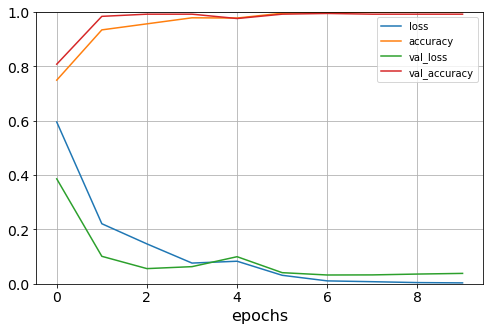

In [59]:
plot_learning_curves(history_CWT)

In [60]:
model_CWT.evaluate(X_test, y_test)

12/12 [==============================] - 2s 149ms/step - loss: 0.0383 - accuracy: 0.9920


[0.03828839957714081, 0.9919999837875366]

In [61]:
prediction_CWT = model_CWT.predict(X_test)
pred_classes_CWT = prediction_CWT.argmax(axis=1)
print(classification_report(y_test, pred_classes_CWT))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       125
           1       0.99      0.99      0.99       115
           2       0.99      0.99      0.99       135

    accuracy                           0.99       375
   macro avg       0.99      0.99      0.99       375
weighted avg       0.99      0.99      0.99       375



Les deux derniers modèles obtiennent clairement de meilleurs résultats. Mais comme dit précédement, le temps de prédiction aussi largement supérieur .. Nous passons de 37ms pour le premier modèle à 137 et 168 ms pour les deux autres. 

In [62]:
#model_CWT.save('netron_model_mobilenetv2.h5')

In [63]:
#import netron
#netron.start('netron_model_mobilenetv2.h5')

Serving 'netron_model_mobilenetv2.h5' at http://localhost:8080


('localhost', 8080)

La cellule ci-dessus permet de voir l'architecture du CNN. 

---

De tels modèle peuvent par exemple être importé sur le site Edge Impulse qui permet ensuite de collecter des données en temps réel grâce à un Arduino ou autre type de deécteur. Cela pourrait servir à évaluer le modèle en temps réel par exemple. 

   # Consignes de rédaction du projet.

Le rapport de projet sera rendu sous la forme d'un seul fichier en format pdf. Il pourra être rédigé sous forme de notebook et exporté ensuite en pdf. 

Le rapport devra comporter :

- une formulation précise des problèmes traités accompagnée d'une présentation du contexte et d'une motivation de leur étude,
- une présentation mathématique des méthodologies utilisées,
- une présentation du protocole utilisé pour faire les expériences,
- une discussion des résultats des expériences,
- une conclusion sous la forme d'un résumé rapide des points importants avec des perspectives éventuelles.
     
Les recherches personnelles et expériences réalisés pour approfondir les exercices sont encouragés et seront valorisés. Les rapports doivent être rédigés individuellement. Les rapports identiques seront pénalisés.

La note tiendra compte :

- de la qualité de la présentation du problème et de méthodologie, notamment pour ce qui concerne la rigueur et justesse mathématiques,
- de la qualité de la mise en oeuvre en python,
- de la pertinence des discussions des résultats,
- de la cohérence et de l'articulation de l'ensemble et de l'originalité.
